In [65]:
import torch
from torch.utils.data import Dataset

class SquatRepDataset(Dataset):
    def __init__(self, data_list, label_list):
        self.data_list = data_list  # list of dicts like the one you provided
        self.label_list = label_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        sequence = torch.tensor([
            data["knee_angle"],
            data["torso_angle"],
            data["hip_angle"],
            data["symmetry_score"],
            data["alignment_score"],
            data["head_angle"],
            data["heel_angle"],
            data["back_angle"],
            data["inter_thigh_angle"],
        ], dtype=torch.float).T  # shape: [seq_len, num_features]

        label = torch.tensor(self.label_list[idx], dtype=torch.long)
        return sequence, label


In [66]:
import torch.nn as nn

class SquatClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SquatClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x_packed):
        packed_output, (h_n, c_n) = self.lstm(x_packed)
        out = self.fc(h_n[-1])  # Final hidden state from last LSTM layer
        return out



In [72]:
# Example data prep
import json
from glob import glob
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

def squat_collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([seq.shape[0] for seq in sequences])  # original lengths
    padded_sequences = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return padded_sequences, lengths, labels

# print(data_list[0])
    
# data_list = [your_json_dict]  # can add more samples here
# label_list = [1]*len(data_list_new)  # class index for this sample

bad_data_list=glob('temp_data/*')
print(bad_data_list)
bad_list_new_list=[]
labels_list=[]
for i in range(len(bad_data_list)):
    bad_list_new_list.extend(glob(bad_data_list[i]+'/*.json'))
    one_hot=[0]*6
    one_hot[i]=1
    # print(one_hot)
    for i in range(len(glob(bad_data_list[i]+'/*.json'))):
        labels_list.append(one_hot)
    # break
# print(labels_list[:2])

bad_data_list_new=[json.load(open(file)) for file in bad_list_new_list]
# print(bad_list_new_list[0])
with open(bad_list_new_list[0]) as f:
    data = json.load(f)
# print(data[1])
bad_data_list_new_actual=[]
label_list_actual=[]
for i in bad_data_list_new:
    for k in range(len(i)):
        label_list_actual.append(labels_list[bad_data_list_new.index(i)])
    for j in i:
        bad_data_list_new_actual.append(j)
bad_data_list=bad_data_list_new_actual
bad_label_list=label_list_actual
# print(data_list[0])
# print(bad_data_list[0])
# print(bad_label_list[0])


    
# data_list = [your_json_dict]  # can add more samples here
# bad_label_list = [0]*len(bad_data_list_new)  # class index for this sample

dataset = SquatRepDataset(bad_data_list, bad_label_list)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create separate dataloaders for training and validation
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    collate_fn=squat_collate_fn
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=8, 
    shuffle=False, 
    collate_fn=squat_collate_fn
)
# print(iter(dataloader).next())  # print one batch of data
# print(dataset[1][0].size())
# # Model
model = SquatClassifier(input_size=9, hidden_size=64, num_classes=6)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
# Training loop (for demonstration, not epoched)
for epoch in range(100):
    model.train()
    avg_loss=0
    for X_batch, lengths, y_batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()

        # Pack sequences
        packed_input = nn.utils.rnn.pack_padded_sequence(X_batch, lengths, batch_first=True, enforce_sorted=False)

        # Pass to model (LSTM expects PackedSequence)
        packed_output, (h_n, c_n) = model.lstm(packed_input)

        # Use the final hidden state from LSTM (last layer)
        logits = model.fc(h_n[-1])  # shape: (batch_size, num_classes)
        y_batch = torch.argmax(y_batch, dim=1)  # from one-hot to class index
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()
        # print(f"Loss: {loss.item()}")
        avg_loss+=loss.item()
    avg_loss/=len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")
    model.eval()
    avg_val_loss=0
    with torch.no_grad():
        for X_batch, lengths, y_batch in tqdm(val_loader, desc="Training"):
            optimizer.zero_grad()

            # Pack sequences
            packed_input = nn.utils.rnn.pack_padded_sequence(X_batch, lengths, batch_first=True, enforce_sorted=False)

            # Pass to model (LSTM expects PackedSequence)
            packed_output, (h_n, c_n) = model.lstm(packed_input)

            # Use the final hidden state from LSTM (last layer)
            logits = model.fc(h_n[-1])  # shape: (batch_size, num_classes)
            y_batch = torch.argmax(y_batch, dim=1)  # from one-hot to class index
            loss = criterion(logits, y_batch)
            optimizer.step()
            # print(f"Loss: {loss.item()}")
            avg_val_loss+=loss.item()
    avg_val_loss/=len(val_loader)
    print(f"Epoch {epoch+1},Val Loss: {avg_val_loss:.4f}")
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)


['temp_data\\bad_back_warp', 'temp_data\\bad_head', 'temp_data\\bad_inner_thigh', 'temp_data\\bad_shallow', 'temp_data\\bad_toe', 'temp_data\\good']


Training: 100%|██████████| 76/76 [00:02<00:00, 37.01it/s]


Epoch 1, Train Loss: 1.7547


Training: 100%|██████████| 19/19 [00:00<00:00, 97.30it/s]


Epoch 1,Val Loss: 1.6936


Training: 100%|██████████| 76/76 [00:01<00:00, 40.43it/s]


Epoch 2, Train Loss: 1.6732


Training: 100%|██████████| 19/19 [00:00<00:00, 199.19it/s]


Epoch 2,Val Loss: 1.6285


Training: 100%|██████████| 76/76 [00:01<00:00, 39.77it/s]


Epoch 3, Train Loss: 1.6410


Training: 100%|██████████| 19/19 [00:00<00:00, 173.97it/s]


Epoch 3,Val Loss: 1.6236


Training: 100%|██████████| 76/76 [00:01<00:00, 40.37it/s]


Epoch 4, Train Loss: 1.6287


Training: 100%|██████████| 19/19 [00:00<00:00, 188.60it/s]


Epoch 4,Val Loss: 1.5901


Training: 100%|██████████| 76/76 [00:01<00:00, 40.30it/s]


Epoch 5, Train Loss: 1.5944


Training: 100%|██████████| 19/19 [00:00<00:00, 110.15it/s]


Epoch 5,Val Loss: 1.5847


Training: 100%|██████████| 76/76 [00:01<00:00, 38.01it/s]


Epoch 6, Train Loss: 1.5709


Training: 100%|██████████| 19/19 [00:00<00:00, 178.14it/s]


Epoch 6,Val Loss: 1.5564


Training: 100%|██████████| 76/76 [00:01<00:00, 40.60it/s]


Epoch 7, Train Loss: 1.5477


Training: 100%|██████████| 19/19 [00:00<00:00, 200.75it/s]


Epoch 7,Val Loss: 1.5669


Training: 100%|██████████| 76/76 [00:01<00:00, 38.29it/s]


Epoch 8, Train Loss: 1.5383


Training: 100%|██████████| 19/19 [00:00<00:00, 205.76it/s]


Epoch 8,Val Loss: 1.5185


Training: 100%|██████████| 76/76 [00:01<00:00, 39.58it/s]


Epoch 9, Train Loss: 1.5047


Training: 100%|██████████| 19/19 [00:00<00:00, 118.01it/s]


Epoch 9,Val Loss: 1.4889


Training: 100%|██████████| 76/76 [00:01<00:00, 40.44it/s]


Epoch 10, Train Loss: 1.4575


Training: 100%|██████████| 19/19 [00:00<00:00, 158.05it/s]


Epoch 10,Val Loss: 1.4820


Training: 100%|██████████| 76/76 [00:02<00:00, 37.81it/s]


Epoch 11, Train Loss: 1.4553


Training: 100%|██████████| 19/19 [00:00<00:00, 183.05it/s]


Epoch 11,Val Loss: 1.4804


Training: 100%|██████████| 76/76 [00:01<00:00, 39.20it/s]


Epoch 12, Train Loss: 1.4491


Training: 100%|██████████| 19/19 [00:00<00:00, 195.04it/s]


Epoch 12,Val Loss: 1.4920


Training: 100%|██████████| 76/76 [00:01<00:00, 39.22it/s]


Epoch 13, Train Loss: 1.4563


Training: 100%|██████████| 19/19 [00:00<00:00, 167.66it/s]


Epoch 13,Val Loss: 1.4933


Training: 100%|██████████| 76/76 [00:02<00:00, 37.89it/s]


Epoch 14, Train Loss: 1.4082


Training: 100%|██████████| 19/19 [00:00<00:00, 172.59it/s]


Epoch 14,Val Loss: 1.4455


Training: 100%|██████████| 76/76 [00:01<00:00, 39.57it/s]


Epoch 15, Train Loss: 1.3936


Training: 100%|██████████| 19/19 [00:00<00:00, 180.49it/s]


Epoch 15,Val Loss: 1.4289


Training: 100%|██████████| 76/76 [00:01<00:00, 39.21it/s]


Epoch 16, Train Loss: 1.3808


Training: 100%|██████████| 19/19 [00:00<00:00, 187.44it/s]


Epoch 16,Val Loss: 1.4282


Training: 100%|██████████| 76/76 [00:02<00:00, 37.77it/s]


Epoch 17, Train Loss: 1.3718


Training: 100%|██████████| 19/19 [00:00<00:00, 192.23it/s]


Epoch 17,Val Loss: 1.4199


Training: 100%|██████████| 76/76 [00:01<00:00, 38.16it/s]


Epoch 18, Train Loss: 1.3549


Training: 100%|██████████| 19/19 [00:00<00:00, 178.94it/s]


Epoch 18,Val Loss: 1.4184


Training: 100%|██████████| 76/76 [00:01<00:00, 39.08it/s]


Epoch 19, Train Loss: 1.3313


Training: 100%|██████████| 19/19 [00:00<00:00, 168.02it/s]


Epoch 19,Val Loss: 1.3929


Training: 100%|██████████| 76/76 [00:02<00:00, 37.45it/s]


Epoch 20, Train Loss: 1.3165


Training: 100%|██████████| 19/19 [00:00<00:00, 150.55it/s]


Epoch 20,Val Loss: 1.3965


Training: 100%|██████████| 76/76 [00:02<00:00, 35.89it/s]


Epoch 21, Train Loss: 1.3106


Training: 100%|██████████| 19/19 [00:00<00:00, 188.42it/s]


Epoch 21,Val Loss: 1.3391


Training: 100%|██████████| 76/76 [00:02<00:00, 36.16it/s]


Epoch 22, Train Loss: 1.2783


Training: 100%|██████████| 19/19 [00:00<00:00, 160.44it/s]


Epoch 22,Val Loss: 1.3519


Training: 100%|██████████| 76/76 [00:02<00:00, 33.11it/s]


Epoch 23, Train Loss: 1.2613


Training: 100%|██████████| 19/19 [00:00<00:00, 179.17it/s]


Epoch 23,Val Loss: 1.3157


Training: 100%|██████████| 76/76 [00:02<00:00, 34.91it/s]


Epoch 24, Train Loss: 1.2705


Training: 100%|██████████| 19/19 [00:00<00:00, 180.43it/s]


Epoch 24,Val Loss: 1.3583


Training: 100%|██████████| 76/76 [00:02<00:00, 37.91it/s]


Epoch 25, Train Loss: 1.2586


Training: 100%|██████████| 19/19 [00:00<00:00, 162.74it/s]


Epoch 25,Val Loss: 1.3253


Training: 100%|██████████| 76/76 [00:01<00:00, 38.67it/s]


Epoch 26, Train Loss: 1.2478


Training: 100%|██████████| 19/19 [00:00<00:00, 176.63it/s]


Epoch 26,Val Loss: 1.3026


Training: 100%|██████████| 76/76 [00:02<00:00, 37.68it/s]


Epoch 27, Train Loss: 1.2216


Training: 100%|██████████| 19/19 [00:00<00:00, 177.79it/s]


Epoch 27,Val Loss: 1.2686


Training: 100%|██████████| 76/76 [00:01<00:00, 38.40it/s]


Epoch 28, Train Loss: 1.2123


Training: 100%|██████████| 19/19 [00:00<00:00, 175.87it/s]


Epoch 28,Val Loss: 1.2748


Training: 100%|██████████| 76/76 [00:01<00:00, 38.99it/s]


Epoch 29, Train Loss: 1.2040


Training: 100%|██████████| 19/19 [00:00<00:00, 196.57it/s]


Epoch 29,Val Loss: 1.2844


Training: 100%|██████████| 76/76 [00:01<00:00, 38.15it/s]


Epoch 30, Train Loss: 1.1912


Training: 100%|██████████| 19/19 [00:00<00:00, 176.47it/s]


Epoch 30,Val Loss: 1.2517


Training: 100%|██████████| 76/76 [00:02<00:00, 33.72it/s]


Epoch 31, Train Loss: 1.1965


Training: 100%|██████████| 19/19 [00:00<00:00, 185.88it/s]


Epoch 31,Val Loss: 1.2941


Training: 100%|██████████| 76/76 [00:01<00:00, 38.35it/s]


Epoch 32, Train Loss: 1.1683


Training: 100%|██████████| 19/19 [00:00<00:00, 172.62it/s]


Epoch 32,Val Loss: 1.2665


Training: 100%|██████████| 76/76 [00:01<00:00, 38.17it/s]


Epoch 33, Train Loss: 1.1694


Training: 100%|██████████| 19/19 [00:00<00:00, 172.86it/s]


Epoch 33,Val Loss: 1.2620


Training: 100%|██████████| 76/76 [00:02<00:00, 37.92it/s]


Epoch 34, Train Loss: 1.1727


Training: 100%|██████████| 19/19 [00:00<00:00, 179.60it/s]


Epoch 34,Val Loss: 1.2461


Training: 100%|██████████| 76/76 [00:02<00:00, 36.38it/s]


Epoch 35, Train Loss: 1.1390


Training: 100%|██████████| 19/19 [00:00<00:00, 175.73it/s]


Epoch 35,Val Loss: 1.2194


Training: 100%|██████████| 76/76 [00:02<00:00, 37.67it/s]


Epoch 36, Train Loss: 1.1046


Training: 100%|██████████| 19/19 [00:00<00:00, 198.04it/s]


Epoch 36,Val Loss: 1.2391


Training: 100%|██████████| 76/76 [00:01<00:00, 39.42it/s]


Epoch 37, Train Loss: 1.1175


Training: 100%|██████████| 19/19 [00:00<00:00, 162.18it/s]


Epoch 37,Val Loss: 1.2706


Training: 100%|██████████| 76/76 [00:01<00:00, 38.53it/s]


Epoch 38, Train Loss: 1.1108


Training: 100%|██████████| 19/19 [00:00<00:00, 174.97it/s]


Epoch 38,Val Loss: 1.2094


Training: 100%|██████████| 76/76 [00:02<00:00, 37.01it/s]


Epoch 39, Train Loss: 1.0987


Training: 100%|██████████| 19/19 [00:00<00:00, 167.68it/s]


Epoch 39,Val Loss: 1.2299


Training: 100%|██████████| 76/76 [00:02<00:00, 37.99it/s]


Epoch 40, Train Loss: 1.0881


Training: 100%|██████████| 19/19 [00:00<00:00, 172.14it/s]


Epoch 40,Val Loss: 1.2074


Training: 100%|██████████| 76/76 [00:01<00:00, 38.10it/s]


Epoch 41, Train Loss: 1.0673


Training: 100%|██████████| 19/19 [00:00<00:00, 171.16it/s]


Epoch 41,Val Loss: 1.2581


Training: 100%|██████████| 76/76 [00:02<00:00, 37.90it/s]


Epoch 42, Train Loss: 1.0614


Training: 100%|██████████| 19/19 [00:00<00:00, 162.78it/s]


Epoch 42,Val Loss: 1.2054


Training: 100%|██████████| 76/76 [00:02<00:00, 35.94it/s]


Epoch 43, Train Loss: 1.0662


Training: 100%|██████████| 19/19 [00:00<00:00, 175.31it/s]


Epoch 43,Val Loss: 1.1972


Training: 100%|██████████| 76/76 [00:01<00:00, 38.74it/s]


Epoch 44, Train Loss: 1.0387


Training: 100%|██████████| 19/19 [00:00<00:00, 175.03it/s]


Epoch 44,Val Loss: 1.1785


Training: 100%|██████████| 76/76 [00:01<00:00, 38.77it/s]


Epoch 45, Train Loss: 1.0420


Training: 100%|██████████| 19/19 [00:00<00:00, 169.09it/s]


Epoch 45,Val Loss: 1.1594


Training: 100%|██████████| 76/76 [00:01<00:00, 38.17it/s]


Epoch 46, Train Loss: 1.0402


Training: 100%|██████████| 19/19 [00:00<00:00, 176.94it/s]


Epoch 46,Val Loss: 1.1628


Training: 100%|██████████| 76/76 [00:02<00:00, 37.77it/s]


Epoch 47, Train Loss: 1.0001


Training: 100%|██████████| 19/19 [00:00<00:00, 170.47it/s]


Epoch 47,Val Loss: 1.1283


Training: 100%|██████████| 76/76 [00:01<00:00, 38.96it/s]


Epoch 48, Train Loss: 1.0132


Training: 100%|██████████| 19/19 [00:00<00:00, 167.15it/s]


Epoch 48,Val Loss: 1.1397


Training: 100%|██████████| 76/76 [00:01<00:00, 38.15it/s]


Epoch 49, Train Loss: 1.0036


Training: 100%|██████████| 19/19 [00:00<00:00, 180.97it/s]


Epoch 49,Val Loss: 1.1871


Training: 100%|██████████| 76/76 [00:01<00:00, 38.81it/s]


Epoch 50, Train Loss: 1.0038


Training: 100%|██████████| 19/19 [00:00<00:00, 168.95it/s]


Epoch 50,Val Loss: 1.1460


Training: 100%|██████████| 76/76 [00:02<00:00, 36.60it/s]


Epoch 51, Train Loss: 0.9718


Training: 100%|██████████| 19/19 [00:00<00:00, 163.17it/s]


Epoch 51,Val Loss: 1.1652


Training: 100%|██████████| 76/76 [00:02<00:00, 35.95it/s]


Epoch 52, Train Loss: 0.9769


Training: 100%|██████████| 19/19 [00:00<00:00, 180.29it/s]


Epoch 52,Val Loss: 1.1646


Training: 100%|██████████| 76/76 [00:01<00:00, 39.14it/s]


Epoch 53, Train Loss: 0.9867


Training: 100%|██████████| 19/19 [00:00<00:00, 170.54it/s]


Epoch 53,Val Loss: 1.1636


Training: 100%|██████████| 76/76 [00:01<00:00, 38.57it/s]


Epoch 54, Train Loss: 0.9631


Training: 100%|██████████| 19/19 [00:00<00:00, 180.44it/s]


Epoch 54,Val Loss: 1.1696


Training: 100%|██████████| 76/76 [00:02<00:00, 36.49it/s]


Epoch 55, Train Loss: 0.9370


Training: 100%|██████████| 19/19 [00:00<00:00, 173.01it/s]


Epoch 55,Val Loss: 1.1731


Training: 100%|██████████| 76/76 [00:01<00:00, 38.46it/s]


Epoch 56, Train Loss: 0.9259


Training: 100%|██████████| 19/19 [00:00<00:00, 168.19it/s]


Epoch 56,Val Loss: 1.1504


Training: 100%|██████████| 76/76 [00:01<00:00, 39.45it/s]


Epoch 57, Train Loss: 0.9277


Training: 100%|██████████| 19/19 [00:00<00:00, 167.04it/s]


Epoch 57,Val Loss: 1.1561


Training: 100%|██████████| 76/76 [00:01<00:00, 38.25it/s]


Epoch 58, Train Loss: 0.9064


Training: 100%|██████████| 19/19 [00:00<00:00, 165.89it/s]


Epoch 58,Val Loss: 1.0876


Training: 100%|██████████| 76/76 [00:02<00:00, 37.42it/s]


Epoch 59, Train Loss: 0.9031


Training: 100%|██████████| 19/19 [00:00<00:00, 164.58it/s]


Epoch 59,Val Loss: 1.1384


Training: 100%|██████████| 76/76 [00:02<00:00, 37.50it/s]


Epoch 60, Train Loss: 0.9104


Training: 100%|██████████| 19/19 [00:00<00:00, 164.29it/s]


Epoch 60,Val Loss: 1.1167


Training: 100%|██████████| 76/76 [00:02<00:00, 37.67it/s]


Epoch 61, Train Loss: 0.8794


Training: 100%|██████████| 19/19 [00:00<00:00, 174.85it/s]


Epoch 61,Val Loss: 1.1403


Training: 100%|██████████| 76/76 [00:01<00:00, 38.39it/s]


Epoch 62, Train Loss: 0.8587


Training: 100%|██████████| 19/19 [00:00<00:00, 181.07it/s]


Epoch 62,Val Loss: 1.0870


Training: 100%|██████████| 76/76 [00:02<00:00, 35.82it/s]


Epoch 63, Train Loss: 0.8688


Training: 100%|██████████| 19/19 [00:00<00:00, 133.88it/s]


Epoch 63,Val Loss: 1.1394


Training: 100%|██████████| 76/76 [00:01<00:00, 38.47it/s]


Epoch 64, Train Loss: 0.8794


Training: 100%|██████████| 19/19 [00:00<00:00, 189.57it/s]


Epoch 64,Val Loss: 1.0739


Training: 100%|██████████| 76/76 [00:01<00:00, 38.40it/s]


Epoch 65, Train Loss: 0.8745


Training: 100%|██████████| 19/19 [00:00<00:00, 173.03it/s]


Epoch 65,Val Loss: 1.0909


Training: 100%|██████████| 76/76 [00:02<00:00, 37.94it/s]


Epoch 66, Train Loss: 0.8683


Training: 100%|██████████| 19/19 [00:00<00:00, 166.36it/s]


Epoch 66,Val Loss: 1.1034


Training: 100%|██████████| 76/76 [00:02<00:00, 36.83it/s]


Epoch 67, Train Loss: 0.8515


Training: 100%|██████████| 19/19 [00:00<00:00, 148.89it/s]


Epoch 67,Val Loss: 1.0970


Training: 100%|██████████| 76/76 [00:02<00:00, 37.82it/s]


Epoch 68, Train Loss: 0.8286


Training: 100%|██████████| 19/19 [00:00<00:00, 154.91it/s]


Epoch 68,Val Loss: 1.0591


Training: 100%|██████████| 76/76 [00:02<00:00, 36.22it/s]


Epoch 69, Train Loss: 0.8385


Training: 100%|██████████| 19/19 [00:00<00:00, 157.94it/s]


Epoch 69,Val Loss: 1.0846


Training: 100%|██████████| 76/76 [00:02<00:00, 37.29it/s]


Epoch 70, Train Loss: 0.8210


Training: 100%|██████████| 19/19 [00:00<00:00, 170.74it/s]


Epoch 70,Val Loss: 1.0587


Training: 100%|██████████| 76/76 [00:02<00:00, 36.76it/s]


Epoch 71, Train Loss: 0.8114


Training: 100%|██████████| 19/19 [00:00<00:00, 167.63it/s]


Epoch 71,Val Loss: 1.0666


Training: 100%|██████████| 76/76 [00:01<00:00, 38.20it/s]


Epoch 72, Train Loss: 0.8084


Training: 100%|██████████| 19/19 [00:00<00:00, 182.21it/s]


Epoch 72,Val Loss: 1.0856


Training: 100%|██████████| 76/76 [00:02<00:00, 37.78it/s]


Epoch 73, Train Loss: 0.8051


Training: 100%|██████████| 19/19 [00:00<00:00, 158.55it/s]


Epoch 73,Val Loss: 1.0917


Training: 100%|██████████| 76/76 [00:01<00:00, 38.48it/s]


Epoch 74, Train Loss: 0.8092


Training: 100%|██████████| 19/19 [00:00<00:00, 182.90it/s]


Epoch 74,Val Loss: 1.0737


Training: 100%|██████████| 76/76 [00:02<00:00, 37.34it/s]


Epoch 75, Train Loss: 0.8051


Training: 100%|██████████| 19/19 [00:00<00:00, 171.94it/s]


Epoch 75,Val Loss: 1.0614


Training: 100%|██████████| 76/76 [00:02<00:00, 37.61it/s]


Epoch 76, Train Loss: 0.8097


Training: 100%|██████████| 19/19 [00:00<00:00, 160.81it/s]


Epoch 76,Val Loss: 1.0986


Training: 100%|██████████| 76/76 [00:02<00:00, 37.06it/s]


Epoch 77, Train Loss: 0.7674


Training: 100%|██████████| 19/19 [00:00<00:00, 174.03it/s]


Epoch 77,Val Loss: 1.0653


Training: 100%|██████████| 76/76 [00:02<00:00, 36.18it/s]


Epoch 78, Train Loss: 0.7713


Training: 100%|██████████| 19/19 [00:00<00:00, 162.93it/s]


Epoch 78,Val Loss: 1.0650


Training: 100%|██████████| 76/76 [00:02<00:00, 36.61it/s]


Epoch 79, Train Loss: 0.7948


Training: 100%|██████████| 19/19 [00:00<00:00, 167.50it/s]


Epoch 79,Val Loss: 1.0936


Training: 100%|██████████| 76/76 [00:02<00:00, 37.27it/s]


Epoch 80, Train Loss: 0.7644


Training: 100%|██████████| 19/19 [00:00<00:00, 163.78it/s]


Epoch 80,Val Loss: 1.0826


Training: 100%|██████████| 76/76 [00:02<00:00, 37.08it/s]


Epoch 81, Train Loss: 0.8027


Training: 100%|██████████| 19/19 [00:00<00:00, 162.14it/s]


Epoch 81,Val Loss: 1.0787


Training: 100%|██████████| 76/76 [00:02<00:00, 37.38it/s]


Epoch 82, Train Loss: 0.7574


Training: 100%|██████████| 19/19 [00:00<00:00, 181.81it/s]


Epoch 82,Val Loss: 1.0448


Training: 100%|██████████| 76/76 [00:02<00:00, 37.06it/s]


Epoch 83, Train Loss: 0.7798


Training: 100%|██████████| 19/19 [00:00<00:00, 173.13it/s]


Epoch 83,Val Loss: 1.0260


Training: 100%|██████████| 76/76 [00:01<00:00, 38.38it/s]


Epoch 84, Train Loss: 0.7413


Training: 100%|██████████| 19/19 [00:00<00:00, 156.28it/s]


Epoch 84,Val Loss: 1.0493


Training: 100%|██████████| 76/76 [00:02<00:00, 36.71it/s]


Epoch 85, Train Loss: 0.7320


Training: 100%|██████████| 19/19 [00:00<00:00, 124.00it/s]


Epoch 85,Val Loss: 1.0776


Training: 100%|██████████| 76/76 [00:02<00:00, 36.90it/s]


Epoch 86, Train Loss: 0.7382


Training: 100%|██████████| 19/19 [00:00<00:00, 168.15it/s]


Epoch 86,Val Loss: 1.0697


Training: 100%|██████████| 76/76 [00:02<00:00, 35.94it/s]


Epoch 87, Train Loss: 0.7400


Training: 100%|██████████| 19/19 [00:00<00:00, 156.68it/s]


Epoch 87,Val Loss: 1.0682


Training: 100%|██████████| 76/76 [00:02<00:00, 37.65it/s]


Epoch 88, Train Loss: 0.7197


Training: 100%|██████████| 19/19 [00:00<00:00, 135.10it/s]


Epoch 88,Val Loss: 1.0823


Training: 100%|██████████| 76/76 [00:02<00:00, 37.48it/s]


Epoch 89, Train Loss: 0.7573


Training: 100%|██████████| 19/19 [00:00<00:00, 169.00it/s]


Epoch 89,Val Loss: 1.0382


Training: 100%|██████████| 76/76 [00:02<00:00, 37.50it/s]


Epoch 90, Train Loss: 0.7080


Training: 100%|██████████| 19/19 [00:00<00:00, 157.49it/s]


Epoch 90,Val Loss: 1.0372


Training: 100%|██████████| 76/76 [00:02<00:00, 35.12it/s]


Epoch 91, Train Loss: 0.7240


Training: 100%|██████████| 19/19 [00:00<00:00, 112.77it/s]


Epoch 91,Val Loss: 1.0497


Training: 100%|██████████| 76/76 [00:02<00:00, 35.55it/s]


Epoch 92, Train Loss: 0.7033


Training: 100%|██████████| 19/19 [00:00<00:00, 165.97it/s]


Epoch 92,Val Loss: 1.0380


Training: 100%|██████████| 76/76 [00:02<00:00, 36.98it/s]


Epoch 93, Train Loss: 0.6768


Training: 100%|██████████| 19/19 [00:00<00:00, 176.53it/s]


Epoch 93,Val Loss: 1.0309


Training: 100%|██████████| 76/76 [00:02<00:00, 37.43it/s]


Epoch 94, Train Loss: 0.6766


Training: 100%|██████████| 19/19 [00:00<00:00, 143.42it/s]


Epoch 94,Val Loss: 1.0877


Training: 100%|██████████| 76/76 [00:02<00:00, 37.71it/s]


Epoch 95, Train Loss: 0.6760


Training: 100%|██████████| 19/19 [00:00<00:00, 176.60it/s]


Epoch 95,Val Loss: 1.0002


Training: 100%|██████████| 76/76 [00:02<00:00, 36.98it/s]


Epoch 96, Train Loss: 0.6949


Training: 100%|██████████| 19/19 [00:00<00:00, 171.48it/s]


Epoch 96,Val Loss: 1.0452


Training: 100%|██████████| 76/76 [00:01<00:00, 38.02it/s]


Epoch 97, Train Loss: 0.6911


Training: 100%|██████████| 19/19 [00:00<00:00, 150.05it/s]


Epoch 97,Val Loss: 1.0086


Training: 100%|██████████| 76/76 [00:02<00:00, 36.09it/s]


Epoch 98, Train Loss: 0.7307


Training: 100%|██████████| 19/19 [00:00<00:00, 158.43it/s]


Epoch 98,Val Loss: 1.0185


Training: 100%|██████████| 76/76 [00:02<00:00, 36.47it/s]


Epoch 99, Train Loss: 0.6804


Training: 100%|██████████| 19/19 [00:00<00:00, 168.75it/s]


Epoch 99,Val Loss: 1.0288


Training: 100%|██████████| 76/76 [00:02<00:00, 36.49it/s]


Epoch 100, Train Loss: 0.6384


Training: 100%|██████████| 19/19 [00:00<00:00, 178.98it/s]

Epoch 100,Val Loss: 1.0208


In [73]:
torch.save(model.state_dict(), 'squat_classifier.pth')

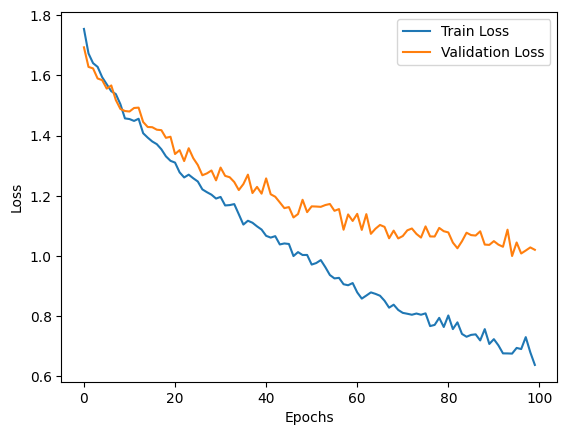

In [74]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, lengths, y_batch in tqdm(val_loader, desc="Evaluation"):
        # Pack sequences
        packed_input = nn.utils.rnn.pack_padded_sequence(X_batch, lengths, batch_first=True, enforce_sorted=False)
        
        # Forward pass
        packed_output, (h_n, c_n) = model.lstm(packed_input)
        logits = model.fc(h_n[-1])
        
        # Get predictions
        predictions = torch.argmax(logits, dim=1)
        y_true = torch.argmax(y_batch, dim=1)
        
        # Store predictions and labels
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_true.cpu().numpy())

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, 
    all_preds, 
    average='weighted'
)

# Print results
print("\nValidation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print per-class metrics
class_names = ['good', 'bad_head', 'bad_shallow', 'bad_inner_thigh', 'bad_toe', 'bad_back_warp']
per_class_p, per_class_r, per_class_f1, _ = precision_recall_fscore_support(
    all_labels, 
    all_preds, 
    average=None
)

print("\nPer-class metrics:")
for i, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    print(f"Precision: {per_class_p[i]:.4f}")
    print(f"Recall: {per_class_r[i]:.4f}")
    print(f"F1-score: {per_class_f1[i]:.4f}")

Evaluation: 100%|██████████| 19/19 [00:00<00:00, 134.03it/s]


Validation Metrics:
Precision: 0.6061
Recall: 0.6026
F1-score: 0.6004

Per-class metrics:

good:
Precision: 0.9000
Recall: 0.8182
F1-score: 0.8571

bad_head:
Precision: 0.3750
Recall: 0.2727
F1-score: 0.3158

bad_shallow:
Precision: 0.5909
Recall: 0.5200
F1-score: 0.5532

bad_inner_thigh:
Precision: 0.5833
Recall: 0.7241
F1-score: 0.6462

bad_toe:
Precision: 0.7778
Recall: 0.7500
F1-score: 0.7636

bad_back_warp:
Precision: 0.4000
Recall: 0.4800
F1-score: 0.4364
